In [1]:
import numpy as np
from random import random
#import helpers as hlp
from tqdm import tqdm
import matplotlib.pyplot as plt
#from derivation_densities import gen_tau, gen_beta, logFCu, ddlogFcu, dlogFcu,compdS

Want to sample from three variables:
1. $\lambda$
2. $\tau$
3. $\beta$

-> these values are then averaged to get the Monte-Carlo estimator
-> first: what is density of $\beta$?

In [ ]:
# import data from DNN training
extracted_coefficients_directory = '../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)

theta_prior = 2.5

In [ ]:
beta = np.repeat(0,10)
# number of samples we want to produce
M = 10000 + 1
L = 10

# number of parameters of theta
q = B_zeta.shape[1] + 1
p = B_zeta.shape[1]

n = B_zeta.shape[0]

# start values for beta, lambda, tau
# beta is taken from trained network and other two
# are initialized randomly
theta_m_1 = np.append(np.zeros(10), np.random.rand(1,))

# stepsize
epsilon = 0.00025

r_m = np.zeros(theta_m_1.shape[0])

tau_start = 0.01

In [ ]:
W = np.array([B_zeta[i,:].dot(B_zeta[i,:]) for i in range(0, n)])
S = np.sqrt(1/(1 + W*tau_start))
S2 = S**2

 need to write functions for
- log-density of $\log \lambda_j^2$
- gradient of log-density of $\log \lambda_j^2$

- log-density of $\log \tau$
- gradient of $\log \tau$

- log-density of $\beta$
- gradient of $\beta$

In [ ]:
def delta_beta(z, u, B, S, beta, tBB):
    return(B.T.dot(z*(1/S)) - beta.T.dot(tBB) - beta/np.exp(u))

def delta_tau(u, B, S2, dS2, z, beta, theta_prior, betaBt):
    p = B.shape[1]
    return(- 0.5*np.sum(dS2/S2) 
           - 0.5*np.sum((z**2)*(-dS2/(S2**2)))
           + np.sum(betaBt*((-0.5*dS2/(S2**1.5))*z)) 
           - (0.5*p - 0.5) 
           + 0.5*(beta.T.dot(beta))/np.exp(u) 
           - 0.5*(np.exp(u)/theta_prior)**0.5 )

def compdS(tau2, W):
    tildeW = tau2*W
    S2 = 1/(1+tildeW)
    dS2 = -tildeW/((1+tildeW)**2)
    ddS2 = -tildeW/((1+tildeW)**2) + 2*(tildeW**2)/((1+tildeW)**3)
    
    S = np.sqrt(S2)
    return(S2, dS2, ddS2, S)


def Delta_theta(vartheta_t, B, n, z, p, tBB, betaBt, W, theta_prior):
    vartheta_new = vartheta_t.copy()
    beta_t = vartheta_new[0:p].reshape(p,)
    u = vartheta_new[p]

    S2, dS2, ddS2, S = compdS(np.exp(u), W)
    
    # Gradient w.r.t. beta
    grad_beta = delta_beta(z, u, B, S, beta_t, tBB)
    # Gradient w.r.t. tau
    grad_tau = delta_tau(u, B, S2, dS2, z, beta_t, theta_prior, betaBt)
    
    return(np.append(grad_beta, grad_tau))

def log_density(z, u,  beta, B, p,  n, S, S2, tBB, theta, betaBt):   
    term1 = - 0.5*np.sum(np.log(S2))
    term2 =  - 0.5*z.dot((1/S2)*z)
    term3 = + betaBt.dot(z*(1/S)) 
    term4 = - 0.5*beta.T.dot(tBB).dot(beta)
    term5 =  - 0.5/np.exp(u)*np.sum(beta**2)
    term6 =  - 0.5*u*(p-1)  - np.sqrt(np.exp(u)/theta)
    return (term1 + term2 + term3 +term4 + term5 + term6  )


def Leapfrog(theta, r, epsilon, n, z, p, B, tBB, betaBt, W, theta_prior, i, L ):
    
    # compute gradient with theta
    #Delta_theta_t = Delta_theta(theta, B, n, z, p, tBB, betaBt, theta, W, theta_prior)

    # update momentum
    #r_tilde = r + (epsilon/2)*Delta_theta_t

    # update theta
    theta_tilde = (theta + epsilon*r).reshape(p + 1,)
    beta_t = theta_tilde[0:p]
    betaBt_t = beta_t.dot(B_zeta.T)
    
    # compute updated gradient
    Delta_theta_tilde = Delta_theta(theta_tilde, B, n, z, p, tBB, betaBt_t, W, theta_prior)
    
    if i != L:
        # update momentum again
        r_tilde = r + (epsilon)*Delta_theta_tilde # old = r + 0.5*epsilon*Delta_theta_tilde
    
    return(theta_tilde, r_tilde)


In [ ]:
r0 = np.repeat(None, M)
theta_tilde = np.repeat(None, M)
r_tilde = np.repeat(None, M)
log_dens =  np.repeat(None, M)
alpha = np.repeat(None, M)
theta_m_1 = np.repeat(None, M)
r_m = np.repeat(None, M)
theta_m_1[0] = np.append(np.zeros(10), np.random.rand(1,))

acc = []
# loop over number of samples that we want to produce
theta_tilde[0] = np.zeros(11)
r_tilde[0] = np.zeros(11)
theta_m_1[1] = np.zeros(11)
all_thetas = []
theta_m_1[0] = np.zeros(11)
r_m[0] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
r_m[1] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
#step_size_tuning = DualAveragingStepSize(initial_step_size=epsilon)
#tune = 100

for m in tqdm(range(1, M - 1)):
    
    # Update S
    # draw momentum from normal distribution
    r0[m] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
    
    # set new parameters
    theta_tilde[m] = theta_m_1[m].reshape(11,)
    r_tilde[m] = r0[m]
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, W, theta_prior)

    # update momentum
    r_tilde[m] = r_tilde[m] + 0.5*epsilon*Delta_theta_t
    
    # generate proposal through L leapfrog updates 
    for i in range(0,L - 1):
        theta_tilde[m], r_tilde[m] = Leapfrog(theta_tilde[m], r_tilde[m], epsilon, n, z, p, B_zeta, tBB, betaBt, W, theta_prior, i, L)
    
    # update momentum
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, W, theta_prior)
    r_tilde[m] = r_tilde[m] + 0.5*epsilon*Delta_theta_t
    
    S2, dS2, ddS2, S = compdS(np.exp(theta_tilde[m][p]), W)
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # probability that proposal is accepted
    log_dens[m] = log_density(z, theta_tilde[m][p],  theta_tilde[m][0:p], B_zeta, p,  n, S, S2, tBB, theta_prior, betaBt)
    proposed_u = log_density(z, theta_m_1[m][p],  theta_m_1[m][0:p], B_zeta, p,  n, S, S2, tBB, theta_prior, betaBt)
    current_K = r_tilde[m].dot(r_tilde[m].T)*0.5
    proposed_K = r_m[m].dot(r_m[m].T)*0.5
    p_accept = log_dens[m] -  proposed_u + current_K - proposed_K
    alpha[m] = np.exp(min([np.log(1), p_accept]))
    
    if np.random.randn() <= alpha[m]:
        theta_m_1[m + 1] = theta_tilde[m]
        r_m[m + 1] = - r_tilde[m]
        acc.append(1)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    else:
        theta_m_1[m + 1] = theta_tilde[m - 1]
        r_m[m + 1] = - r_tilde[m - 1]
        acc.append(0)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    if (m % 100 == 0) & (m > 1):
        print(np.mean(acc[-100:]))


In [ ]:
np.mean(acc)

In [ ]:
epsilon

In [ ]:
plt.plot(all_thetas)
plt.ylim(-.1,.1)

In [ ]:
#np.save('../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Ridge/vartheta_1000runs.npy', np.array(all_thetas))

In [105]:
all_thetas = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas.npy')

In [106]:
acc = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/acc.npy')

In [107]:
np.mean(acc)

1.0

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_thetas[:])
#plt.ylim(-.5,.5)

In [93]:
df = np.array(all_thetas)

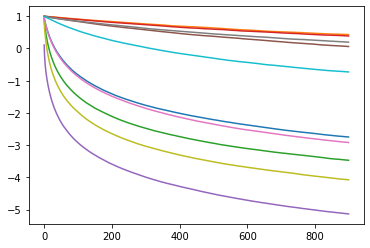

In [94]:
for i in range(10,20):
    plt.plot(df[:,i])
#plt.ylim(-0.5, .2)

In [33]:
vartheta_va = np.load('../../../../data/commaai/va/unfiltered_gaussian_resampled/Horseshoe/mu_ts.npy')

In [36]:
vartheta_va_m = np.mean(vartheta_va[20000:,:,:].reshape(9001, 21), axis= 0)

In [40]:
vartheta_va_m[10:20] = np.mean(np.exp(0.5*vartheta_va[20000:,10:20,:].reshape(9001, 10)), axis= 0)
vartheta_va_m[20] = np.mean(np.exp(0.5*vartheta_va[20000:,20,:].reshape(9001, 1)), axis= 0)

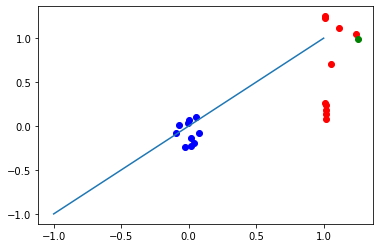

In [95]:
plt.scatter(vartheta_va_m[0:10], df[850,:][0:10], color = 'b')
plt.scatter(np.exp(0.5*vartheta_va_m[10:20]),np.exp(0.5*df[850,:][10:20]), color = 'r')
plt.scatter(np.exp(vartheta_va_m[20]), np.exp(df[850,:][20]), color = 'g')
ident = [-1, 1]
plt.plot(ident,ident)

In [ ]:
theta_hmc = np.mean(all_thetas[50:], axis = 0)

In [ ]:
theta_hmc = all_thetas[0]

In [ ]:
# comparison with VA

In [ ]:
vartheta_va = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts.npy')

In [ ]:
vartheta_va.shape

In [ ]:
theta_va = np.mean(vartheta_va[20000:, :], axis = 0)

In [73]:
plt.scatter(np.append(theta_hmc[0:10], np.exp(theta_hmc[10])), np.append(theta_va[0:10], np.exp(theta_va[10])))
ident = [-.5, .5]
plt.plot(ident,ident)

NameError: name 'theta_hmc' is not defined

In [ ]:
all_thetas_mu = np.mean(np.array(all_thetas)[100:,:], axis = 0)
all_thetas_sd = np.std(np.array(all_thetas)[100:,:], axis = 0)
vartheta_va_mu = np.mean(vartheta_va[int(0.7*50000):50000,:], axis = 0)
vartheta_va_sd = np.std(vartheta_va[int(0.7*50000):50000,:], axis = 0)

In [ ]:
sd = []
for i in range(0,df.shape[1]):
    sd.append(np.std(df[50:,i]))

In [74]:
sd_va = np.load('../../../../data/commaai/va/unfiltered_gaussian_resampled/Horsesho/var.npy')

In [81]:
B_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts.npy')
d_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts.npy')

In [85]:
B_ts_va = np.mean(B_ts[27000:,:,:], axis = 0)
d_ts_va = np.mean(d_ts[27000:,:,:], axis = 0)

In [86]:
sd_va = np.sqrt(np.diag(B_ts_va.dot(B_ts_va.T) + np.diag(d_ts_va**2)))

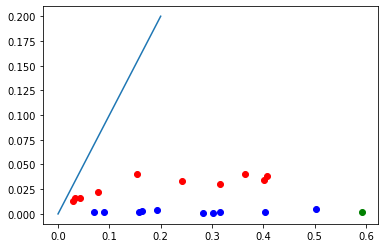

In [88]:
plt.scatter(sd_va[0:10], sd[0:10], color = 'b')
plt.scatter(sd_va[10:20], sd[10:20], color = 'r')
plt.scatter(sd_va[20], sd[20], color = 'g')
ident= [0, .2]
plt.plot(ident,ident)

In [ ]:
sd

In [ ]:
all_thetas_sd

In [ ]:
[0.00760327647016553,
 0.008326927717681377,
 0.01250457140820367,
 0.004461071248228526,
 0.01174420433709533,
 0.004387470821945021,
 0.0063200012480122015,
 0.00940849677155538,
 0.01439538597797563,
 0.005273555509929353,
 0.1277228295874986]

In [ ]:
beta_va.shape

In [ ]:
all_thetas = np.load('../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Ridge/vartheta_trynew_superlargeL.npy')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_thetas)
#plt.ylim(0.7,1.2)

In [ ]:
df = np.array(all_thetas)

In [ ]:
plt.plot(df[:,10])
#plt.ylim(0 ,1)

In [ ]:
all_thetas_mu = np.mean(all_thetas[1000:,:], axis = 0)
all_thetas_sd = np.std(all_thetas[1000:,:], axis = 0)

In [ ]:
all_thetas.shape

In [ ]:
2*2*2

In [ ]:
vartheta_va = np.load('../../../../data/commaai/va/unfiltered_gaussian_resampled/Ridge/vartheta.npy')

In [ ]:
vartheta_va = vartheta_va.reshape(50000, 11)

In [ ]:
vartheta_va_mu = np.mean(vartheta_va[int(0.9*50000):50000,:], axis = 0)
vartheta_va_sd = np.std(vartheta_va[int(0.9*50000):50000,:], axis = 0)

In [ ]:
plt.scatter(all_thetas_mu[0:10], vartheta_va_mu[0:10])
ident = [-1, 1.0]
plt.plot(ident,ident)

In [ ]:
print(vartheta_va_mu[10], all_thetas_mu[10])

In [ ]:
plt.scatter(vartheta_va_sd, all_thetas_sd)
ident = [0, 0.175]
plt.plot(ident,ident)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(vartheta_va_sd, all_thetas_sd)
ident = [0, 0.175]
ax.plot(ident,ident)

n = [1,2,3,4,5,6,7,8,9,10,11]

for i, txt in enumerate(n):
    ax.annotate(txt, (vartheta_va_sd[i], all_thetas_sd[i]))